# Examining Flight On-Time Data

This project handles the [Airline On-Time Performance Data](https://www.transtats.bts.gov/DL_SelectFields.asp?gnoyr_VQ=FGJ&QO_fu146_anzr=b0-gvzr) from the Bureau of Transportation Statistics.

### Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Read Data from CSV
We assume our data is downloaded and unzipped in our local directory, so we use the function read_csv() to create our initial dataframe. With function head() we get a glimpse of what our data looks like.

In [2]:
data_filename = '515364771_T_ONTIME_REPORTING.csv'
data = pd.read_csv(data_filename, parse_dates=['FL_DATE'])
data.head(3)

,FL_DATE,TAIL_NUM,CARRIER,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 19
0,2018-01-01,N8891A,9E,GFK,"Grand Forks, ND",MSP,"Minneapolis, MN",1302.0,-8.0,1417.0,-12.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,N8891A,9E,MSP,"Minneapolis, MN",GFK,"Grand Forks, ND",1124.0,9.0,1234.0,-11.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,N293PQ,9E,DTW,"Detroit, MI",SAT,"San Antonio, TX",2022.0,4.0,2232.0,-50.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


### Airport Misery Index
Our first task is to determine the possibility that a flight is going to be delayed according to the airport it will be departing from. This will be indicated by the percentage of delayed flights for the said airport.

First, we create a separate dataframe that contains the information we are interested in. We use the .loc function to choose the rows with valid numerical values in the DEP_DELAY column, which indicates the delay from the scheduled departure time in minutes. At the same time, we pick only the DEP_DELAY and ORIGIN columns.

In [3]:
df1 = data.loc[data.DEP_DELAY.isna() == False,('ORIGIN','DEP_DELAY')]
df1

,ORIGIN,DEP_DELAY
0,GFK,-8.0
1,MSP,9.0
2,DTW,4.0
3,BOS,104.0
4,MSP,1.0
...,...,...
7213441,RDU,4.0
7213442,JFK,11.0
7213443,BOS,25.0
7213444,MCO,1.0


We group by columns 'ORIGIN' so we can use aggregate functions.

In [4]:
grouped_df1 = df1.groupby('ORIGIN')
grouped_df1.head(5)

,ORIGIN,DEP_DELAY
0,GFK,-8.0
1,MSP,9.0
2,DTW,4.0
3,BOS,104.0
4,MSP,1.0
...,...,...
6980261,ART,13.0
6985191,ART,6.0
6985290,ART,78.0
7016332,ART,10.0


We use the aggregate function 'count' to get the total number of flights per airport.
Then we use this dataframe to take out the outlier-airports (the ones with very few flights). For this we use the loc function with a quantile condition as a parameter.

In [5]:
flight_count_df1 = grouped_df1.agg('count')
flight_count_df1 = flight_count_df1.loc[flight_count_df1.DEP_DELAY > flight_count_df1.DEP_DELAY.quantile(0.01)]
flight_count_df1

,DEP_DELAY
ORIGIN,
ABE,4078
ABI,1981
ABQ,23813
ABR,737
ABY,995
...,...
WRG,716
WYS,239
XNA,12325


Here we use the lambda function to get the count of delayed flights per airport. According to the documentation of the aviation data, a flight is considered delayed if it departs at least 15 minutes after its scheduled time.

In [6]:
delayed_flight_count_1 = df1.groupby('ORIGIN')['DEP_DELAY'].apply(lambda x: (x>=15.0).sum()).reset_index(name='DELAYED_FLIGHTS')
delayed_flight_count_1.set_index('ORIGIN',inplace=True)
delayed_flight_count_1

,DELAYED_FLIGHTS
ORIGIN,
ABE,720
ABI,336
ABQ,4263
ABR,86
ABY,159
...,...
WYS,11
XNA,2137
YAK,60


Now we are ready to calculate the airports' misery index as a percentage of delayed flights to the overall number of flights of each airport. Since we took out outliers from the flight_count_df1 dataframe, but they still exist in delayed_flight_count, the probability for outliers cannot be calculated and gets the value NaN. So we drop these rows with dropna().

In [7]:
delay_possibility_1 = delayed_flight_count_1.DELAYED_FLIGHTS / flight_count_df1.DEP_DELAY
delay_possibility_1 = delay_possibility_1.dropna()
delay_possibility_1.rename('DELAY_POSSIBILITY',inplace=True)
delay_possibility_1

ORIGIN
ABE    0.176557
ABI    0.169611
ABQ    0.179020
ABR    0.116689
ABY    0.159799
         ...   
WRG    0.107542
WYS    0.046025
XNA    0.173387
YAK    0.084270
YUM    0.074128
Name: DELAY_POSSIBILITY, Length: 354, dtype: float64

Now we will use a different metric to evaluate airports. We will examine the mean and median delay of their departing flights. Again we use the aggregate functions mean() and median() and we merge the resulting data.

In [8]:
mean_df1 = grouped_df1.mean()
median_df1 = grouped_df1.median()
desc_df1 = pd.merge(mean_df1,median_df1,on='ORIGIN')
desc_df1.columns = ['MEAN_DELAY','MEDIAN_DELAY']
desc_df1.sort_values(by='MEAN_DELAY',inplace=True)
desc_df1

,MEAN_DELAY,MEDIAN_DELAY
ORIGIN,,
YAK,-8.720506,-13.0
EAR,-7.884422,-13.0
SCC,-7.606717,-13.0
PSG,-6.861345,-12.0
BRW,-6.831933,-11.0
...,...,...
MMH,33.503704,-1.0
HYA,34.397727,3.5
ART,36.333333,16.0


Finally we generate our complete dataframe containing both the misery index and the mean and median delay using and inner join

In [10]:
stats_df1 = pd.merge(delay_possibility_1, desc_df1, how='inner', on='ORIGIN')
stats_df1.columns = ['DELAY_POSSIBILITY','MEAN_DELAY','MEDIAN_DELAY']
stats_df1.sort_values(by=['DELAY_POSSIBILITY'],ascending=False,inplace=True)
stats_df1

,DELAY_POSSIBILITY,MEAN_DELAY,MEDIAN_DELAY
ORIGIN,,,
SCK,0.398111,24.265857,8.0
HGR,0.369565,26.760870,0.0
OWB,0.364486,27.635514,3.0
OTH,0.351955,29.173184,-2.0
TTN,0.330020,25.308151,0.0
...,...,...,...
LWS,0.055866,-2.472067,-8.0
LBF,0.055160,-3.275801,-9.0
WYS,0.046025,-2.485356,-5.0


### Airline Misery Index
As a second task we will do the same analysis but for the airlines, to see how they may cause delays.

To do this we will later need the full commercial name of the airline, which is included in a separate file which we read.

In [11]:
carriers = pd.read_csv('L_UNIQUE_CARRIERS.csv_', index_col='Code')
carriers.index.rename('CARRIER', inplace=True)
carriers

,Description
CARRIER,
02Q,Titan Airways
04Q,Tradewind Aviation
05Q,"Comlux Aviation, AG"
06Q,Master Top Linhas Aereas Ltd.
07Q,Flair Airlines Ltd.
...,...
ZW,Air Wisconsin Airlines Corp
ZX,Air Georgian
ZX (1),Airbc Ltd.


Again we pick the columns we need, which are the carrier and the delay, and drop any non-numerical values as delay.

In [12]:
df2 = data.loc[data.DEP_DELAY.isna() == False,('CARRIER','DEP_DELAY')]
df2

,CARRIER,DEP_DELAY
0,9E,-8.0
1,9E,9.0
2,9E,4.0
3,9E,104.0
4,9E,1.0
...,...,...
7213441,B6,4.0
7213442,B6,11.0
7213443,B6,25.0
7213444,B6,1.0


Next we group by the carrier, as we did earlier with the airports.

In [13]:
grouped_df2 = df2.groupby('CARRIER')
grouped_df2.head()

,CARRIER,DEP_DELAY
0,9E,-8.0
1,9E,9.0
2,9E,4.0
3,9E,104.0
4,9E,1.0
...,...,...
17411,AS,-3.0
17412,AS,-11.0
17413,AS,-13.0
17414,AS,-8.0


We then calculate the total of flights per carrier with 'couunt'.

In [14]:
flight_count_df2 = grouped_df2.agg('count')
flight_count_df2

,DEP_DELAY
CARRIER,
9E,235061
AA,902562
AS,243670
B6,298738
DL,945888
EV,197324
F9,117747
G4,95473
HA,83486


Now we find the total of delayed flight per carrier.

In [15]:
delayed_flight_count_2 = df2.groupby('CARRIER')['DEP_DELAY'].apply(lambda x: (x>=15.0).sum()).reset_index(name='DELAYED_FLIGHTS')
delayed_flight_count_2.set_index('CARRIER',inplace=True)
delayed_flight_count_2

,DELAYED_FLIGHTS
CARRIER,
9E,41583
AA,165775
AS,32165
B6,80223
DL,134218
EV,36716
F9,34537
G4,20508
HA,6315


And we are ready to calculate the misery index again, this time for airlines.

In [17]:
delay_possibility_2 = delayed_flight_count_2.DELAYED_FLIGHTS / flight_count_df2.DEP_DELAY
delay_possibility_2 = delay_possibility_2.dropna()
delay_possibility_2.rename('DELAY_POSSIBILITY',inplace=True)
delay_possibility_2

CARRIER
9E    0.176903
AA    0.183672
AS    0.132002
B6    0.268540
DL    0.141896
EV    0.186070
F9    0.293315
G4    0.214804
HA    0.075641
MQ    0.172285
NK    0.165463
OH    0.204251
OO    0.163922
UA    0.172244
VX    0.175386
WN    0.225839
YV    0.177065
YX    0.158889
Name: DELAY_POSSIBILITY, dtype: float64

Then we get the mean and median delay per carrier

In [18]:
mean_df2 = grouped_df2.mean()
median_df2 = grouped_df2.median()
desc_df2 = pd.merge(mean_df2,median_df2,on='CARRIER')
desc_df2.columns = ['MEAN_DELAY','MEDIAN_DELAY']
desc_df2.sort_values(by=['MEAN_DELAY'],ascending=False,inplace=True)
desc_df2

,MEAN_DELAY,MEDIAN_DELAY
CARRIER,,
F9,19.684102,-1.0
B6,15.869267,-2.0
G4,12.922575,-2.0
EV,12.319338,-4.0
OH,12.038332,-2.0
YV,11.226541,-3.0
WN,11.138968,0.0
9E,10.732733,-4.0
OO,10.112660,-4.0


Finally we create our complete table again, showing all our metrics about the delays on flights per carrier.

In [20]:
stats_df2 = pd.merge(delay_possibility_2, desc_df2, how='inner', on='CARRIER')
stats_df2.sort_values(by=['DELAY_POSSIBILITY'],ascending=False,inplace=True)
stats_df2

,DELAY_POSSIBILITY,MEAN_DELAY,MEDIAN_DELAY
CARRIER,,,
F9,0.293315,19.684102,-1.0
B6,0.268540,15.869267,-2.0
WN,0.225839,11.138968,0.0
G4,0.214804,12.922575,-2.0
OH,0.204251,12.038332,-2.0
EV,0.186070,12.319338,-4.0
AA,0.183672,10.078218,-2.0
YV,0.177065,11.226541,-3.0
9E,0.176903,10.732733,-4.0


### Distribution of Departures
Now we want to split the airports in groups depending on their total number of departures. To do so we will use a histogram to visualize the data.

In [24]:
flight_count_df3 = df1.groupby('ORIGIN').agg('count')
flight_count_df3.sort_values(by=['DEP_DELAY'])
flight_count_df3

,DEP_DELAY
ORIGIN,
ABE,4078
ABI,1981
ABQ,23813
ABR,737
ABY,995
...,...
WYS,239
XNA,12325
YAK,712


Now we got the total amount of flights per airport and we see that it ranges from 2 to 387024. We choose to split in 18 groups using logarithmic scaling, so that the visual result is more user friendly.

(array([ 0.,  1.,  4., 12.,  7., 12., 81., 40., 52., 44., 32., 24., 18.,
        13., 14.,  3.,  0.]),
 array([1.00000000e+01, 1.96841945e+01, 3.87467512e+01, 7.62698586e+01,
        1.50131073e+02, 2.95520924e+02, 5.81709133e+02, 1.14504757e+03,
        2.25393390e+03, 4.43668733e+03, 8.73326162e+03, 1.71907220e+04,
        3.38385515e+04, 6.66084629e+04, 1.31113394e+05, 2.58086154e+05,
        5.08021805e+05, 1.00000000e+06]),
 <a list of 17 Patch objects>)

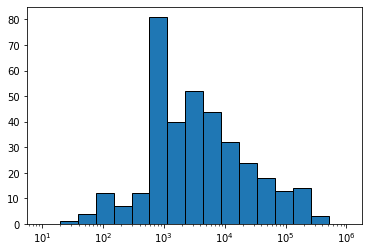

In [25]:
plt.xscale('log')
q3_hist = plt.hist(flight_count_df3.DEP_DELAY,bins=np.logspace(1, 6, num=18),edgecolor='black')
q3_hist

### Temporal Distribution of Delays
The next task is to visualize the delays that occur in different months of the year, always compared to the total amount of flights of the said month.

In [26]:
df4 = data.loc[data.DEP_DELAY.isna() == False,('FL_DATE','DEP_DELAY')]
df4['MONTH'] = df4.FL_DATE.dt.month
df4['DELAYED'] = df4.DEP_DELAY >= 15.0
df4

,FL_DATE,DEP_DELAY,MONTH,DELAYED
0,2018-01-01,-8.0,1,False
1,2018-01-01,9.0,1,False
2,2018-01-01,4.0,1,False
3,2018-01-01,104.0,1,True
4,2018-01-01,1.0,1,False
...,...,...,...,...
7213441,2018-12-31,4.0,12,False
7213442,2018-12-31,11.0,12,False
7213443,2018-12-31,25.0,12,True
7213444,2018-12-31,1.0,12,False


To do so we use the month function of pandas to get the month in which a flight happened. We store this information in a new column and we also create a column about whether the flight was delayed or not.
Next we will use the pivot_table function to get the count of delayed and non-delayed flights per month.

In [27]:
by_month = df4.pivot_table(index='MONTH', 
                                     columns='DELAYED',
                                     values='FL_DATE',
                                     aggfunc='count')
by_month

DELAYED,False,True
MONTH,,
1,453644,99151
2,418775,92854
3,495974,98357
4,489744,99685
5,492528,116605
6,483365,131835
7,494337,139809
8,495122,137198
9,489081,88795


Now we are ready to create a barplot. We chose to make it stacked, so the differences are more obvious for the human eye.

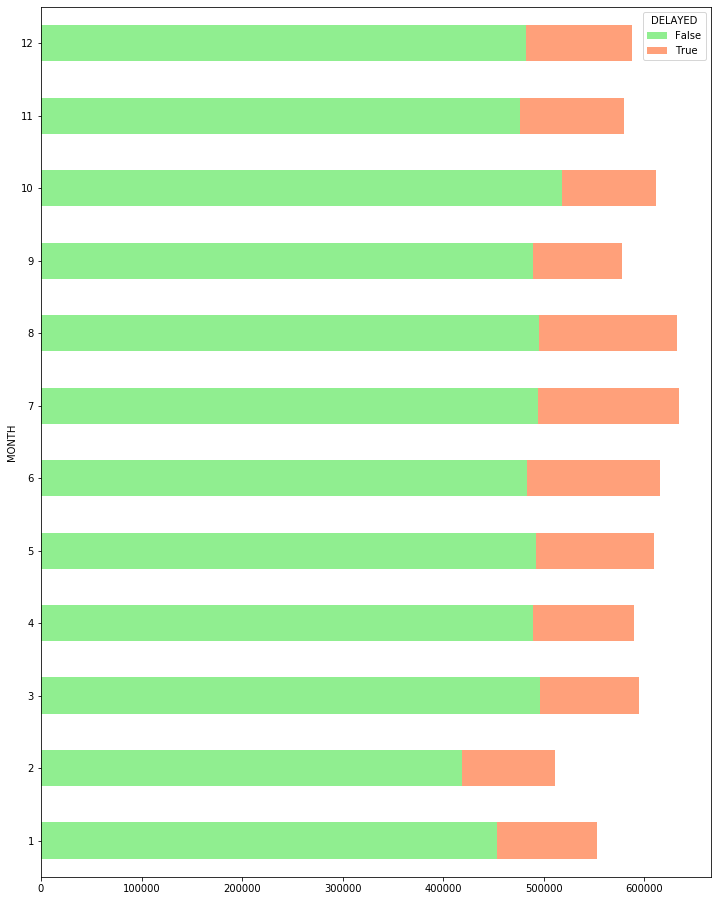

In [28]:
ax = by_month.plot(kind='barh', color=('lightgreen', 'lightsalmon'), figsize=(12, 16), stacked=True)

### Ideal Carrier per Departure and Destination Combo
Our last task for this project is to find out which carrier has the best performance in terms of average delay for every sigle route.

In [29]:
df5 = data.loc[data.DEP_DELAY.isna() == False,('ORIGIN','DEST','CARRIER','DEP_DELAY')]
df5

,ORIGIN,DEST,CARRIER,DEP_DELAY
0,GFK,MSP,9E,-8.0
1,MSP,GFK,9E,9.0
2,DTW,SAT,9E,4.0
3,BOS,CVG,9E,104.0
4,MSP,CLT,9E,1.0
...,...,...,...,...
7213441,RDU,BOS,B6,4.0
7213442,JFK,MCO,B6,11.0
7213443,BOS,TPA,B6,25.0
7213444,MCO,LGA,B6,1.0


To achieve this we select the ORIGIN, DEST, CARRIER and DEP_DELAY columns of our initial dataset and then we group by ORIGIN DEST and CARRIER in this order.

In [30]:
sort_df5 = df5.groupby(['ORIGIN','DEST','CARRIER'],as_index=True)
sort_df5.head()

,ORIGIN,DEST,CARRIER,DEP_DELAY
0,GFK,MSP,9E,-8.0
1,MSP,GFK,9E,9.0
2,DTW,SAT,9E,4.0
3,BOS,CVG,9E,104.0
4,MSP,CLT,9E,1.0
...,...,...,...,...
7206236,ORD,BTV,YX,-5.0
7206319,DEN,OMA,YX,191.0
7209906,EWR,MKE,UA,-2.0
7210839,MSP,RAP,9E,947.0


Now we are ready to use mean() function to get the average dealy minutes for each combination. 

In [31]:
mean_delay = sort_df5.DEP_DELAY.mean()
mean_delay

ORIGIN  DEST  CARRIER
ABE     ATL   9E          11.991379
              DL           7.530387
              EV          10.433735
        CLT   OH           5.063527
        DTW   OO          15.946507
                            ...    
YAK     CDV   AS          -4.081921
        JNU   AS         -13.307263
YNG     PIE   G4         111.000000
        SFB   G4          15.000000
YUM     PHX   OO          -0.455669
Name: DEP_DELAY, Length: 13046, dtype: float64

To do the calculations we unstack the Series we got and go on to find the minimum average delay per combo.

In [32]:
mean_delay = mean_delay.unstack()
min_del = mean_delay.min(axis=1)
min_del.rename('MINIMUM_AVERAGE_DELAY',inplace=True)
min_del

ORIGIN  DEST
ABE     ATL       7.530387
        CLT       5.063527
        DTW      15.946507
        FLL      40.708333
        MDT     175.000000
                   ...    
YAK     CDV      -4.081921
        JNU     -13.307263
YNG     PIE     111.000000
        SFB      15.000000
YUM     PHX      -0.455669
Name: MINIMUM_AVERAGE_DELAY, Length: 6361, dtype: float64

We also need to know the carrier with this performance so we use idxmin()

In [33]:
min_del_car = mean_delay.idxmin(axis=1)
min_del_car.rename('CARRIER',inplace=True)
min_del_car

ORIGIN  DEST
ABE     ATL     DL
        CLT     OH
        DTW     OO
        FLL     G4
        MDT     OO
                ..
YAK     CDV     AS
        JNU     AS
YNG     PIE     G4
        SFB     G4
YUM     PHX     OO
Name: CARRIER, Length: 6361, dtype: object

Now we can merge our results to a final table that can tell us which carrier has the best performance for our selected route.

In [34]:
merged_min_del = pd.merge(min_del_car,min_del,on=['ORIGIN','DEST'])
merged_min_del.reset_index(inplace=True)
merged_min_del = merged_min_del.merge(carriers,on='CARRIER')
merged_min_del.set_index(['ORIGIN','DEST'],inplace=True)
merged_min_del.sort_index(axis=0,inplace=True)
merged_min_del

CARRIER  MINIMUM_AVERAGE_DELAY            Description
ORIGIN DEST                                                      
ABE    ATL       DL               7.530387   Delta Air Lines Inc.
       CLT       OH               5.063527      PSA Airlines Inc.
       DTW       OO              15.946507  SkyWest Airlines Inc.
       FLL       G4              40.708333          Allegiant Air
       MDT       OO             175.000000  SkyWest Airlines Inc.
...             ...                    ...                    ...
YAK    CDV       AS              -4.081921   Alaska Airlines Inc.
       JNU       AS             -13.307263   Alaska Airlines Inc.
YNG    PIE       G4             111.000000          Allegiant Air
       SFB       G4              15.000000          Allegiant Air
YUM    PHX       OO              -0.455669  SkyWest Airlines Inc.

[6361 rows x 3 columns]

If someone working in customer service wanted to use this table to advise a customer, they could make use of a function like the following:

In [35]:
def best_carrier_for_route(origin,destination):
    best = merged_min_del.loc[(origin,destination),'Description']
    return best

best_carrier_for_route('ABE','ATL')

'Delta Air Lines Inc.'